### LING 583 Final Project

# Learn from the best
## with the Yelp data
- source: 'yelp.com/dataset/download'


### Glen Heungyong Im


In [1]:
import pandas as pd
import numpy as np
import re
import random
import googlemaps
from datetime import datetime
import json
import os
import spacy
from cytoolz import identity
from collections import Counter
from cytoolz import take, concat
nlp = spacy.load('en')
import folium
from folium import plugins
from folium.plugins import MeasureControl
from folium.plugins import FloatImage

### Load .json Data

In [2]:
os.chdir('C:\\Users\\Glen\\glen\\Project')

In [24]:
with open('business.json', encoding='utf8') as f:
    data = [json.loads(row) for row in f]

business = pd.DataFrame(data)
business.shape

(192609, 14)

In [4]:
with open('checkin.json', encoding='utf8') as f:
    data = [json.loads(row) for row in f]

checkin = pd.DataFrame(data)
checkin.shape

(161950, 2)

In [5]:
with open('tip.json', encoding='utf8') as f:
    data = [json.loads(row) for row in f]

tips = pd.DataFrame(data)
tips.shape

(1223094, 5)

## Extract keywords

In [25]:
def tokenize(text):
    return [tok.orth_ for tok in nlp.tokenizer(text)]

In [26]:
cat = pd.DataFrame(tokenize(business['categories'].str.cat()))

In [27]:
categories = []
for key in cat[0]:
    k = re.findall('[A-Z][^A-Z1-9]*', key)
    for i in k:
        categories.append(i)

In [28]:
category = []
count = []
for index in Counter(categories).items():
    category.append(index[0])
    count.append(index[1])

## Frequency of Categories

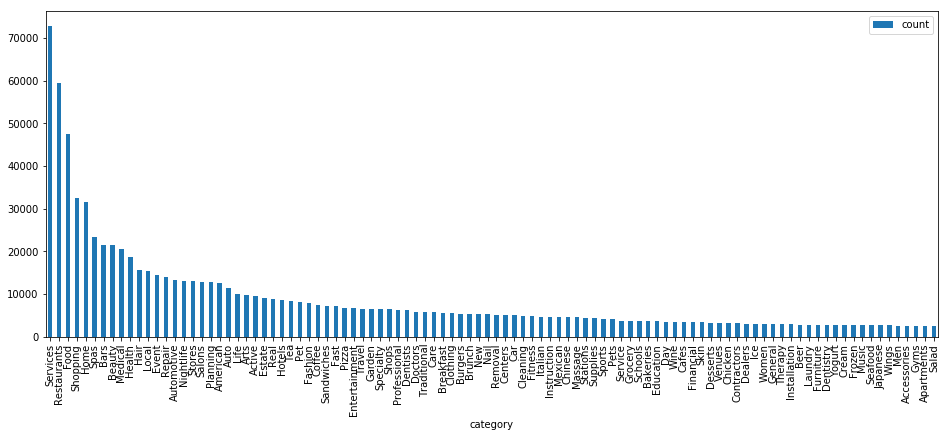

In [29]:
freq = pd.DataFrame({'category':category,
                    'count':count})

freq.sort_values(by='count', ascending=False).head(100).plot.bar(x='category', figsize=(16,6))

In [30]:
doc=[]
# print([(X, X.ent_iob_, X.ent_type_) for X in category])
for i in category:
    sent = nlp(i)
    for ent in sent.ents:
        doc.append([ent.text, ent.label_])

In [31]:
cat_df = pd.DataFrame(doc)
cat_df.columns=['category', 'tag']
authentic = cat_df['category'].loc[cat_df['tag'].isin(['NORP', 'LANGUAGE'])]

In [13]:
print([i for i in authentic])

['Chinese', 'Japanese', 'Mexican', 'Irish', 'Italian', 'European', 'Persian', 'Iranian', 'Polish', 'Korean', 'Canadian', 'Portuguese', 'Vietnamese', 'Asian', 'Vegetarian', 'French', 'Hawaiian', 'Taiwanese', 'Pakistani', 'Indian', 'Filipino', 'Hakka', 'Peruvian', 'Greek', 'Latin', 'Lebanese', 'Cantonese', 'Pediatricians', 'Malaysian', 'Hungarian', 'British', 'German', 'Brazilian', 'Laotian', 'Honduran', 'Salvadoran', 'Nicaraguan', 'Ethiopian', 'Magicians', 'Spanish', 'Basque', 'Russian', 'Cambodian', 'Trinidadian', 'Syrian', 'Scottish', 'Argentine', 'Australian', 'Cuban', 'Austrian', 'Armenian', 'Nepalese', 'Buddhist', 'Singaporean', 'Shanghainese', 'Indonesian', 'Burmese', 'Colombian', 'Egyptian', 'Czech', 'Hindu', 'Scandinavian', 'Iberian', 'Bulgarian', 'Calabrian']


In [32]:
authentic = authentic[~authentic.isin(['Magicians', 'Pediatricians', 'Buddhist'])]

In [202]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [16]:
wordcloud = WordCloud().generate(authentic.to_string())

## Extracted Keywords

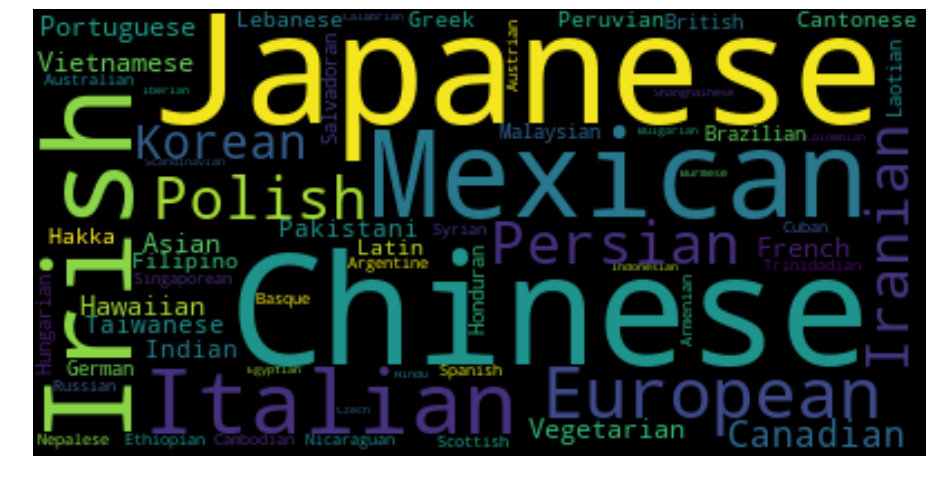

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=[16,12])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [33]:
indices = []
for i, category in enumerate(business.categories):
    if category is None:
        continue
    if any(elem in category.split(',') for elem in authentic):
        indices.append(i)

In [34]:
fbiz = business.loc[indices]

## Histogram of Star Rate

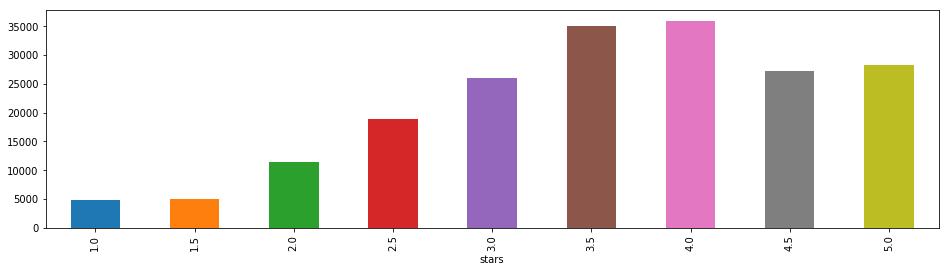

In [20]:
business.groupby('stars').size().plot.bar(figsize=(16,4))

## Histogram of Star Rate in Food Places

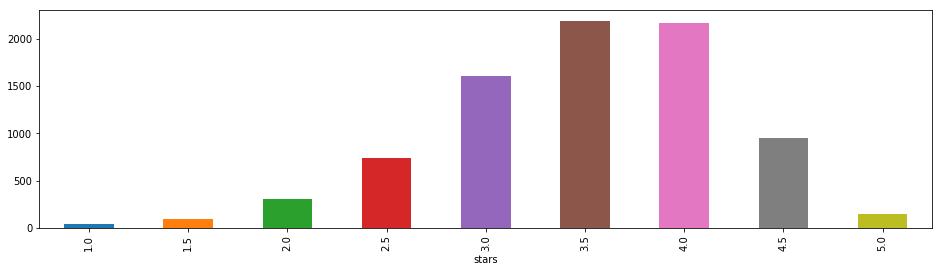

In [21]:
fbiz.groupby('stars').size().plot.bar(figsize=(16,4))

In [22]:
dict = {}
# print([(X, X.ent_iob_, X.ent_type_) for X in category])

for i in fbiz[fbiz['stars'] == 5.0]['categories']:
    ents = tokenize(i)
    for ent in ents:
        if ent in dict.keys():
            dict[ent] += 1
        else:
            dict[ent] = 1

In [23]:
dict = pd.DataFrame.from_dict(dict, orient='index', columns=['count'])
dict = dict.drop([',', ')', '(', '&'])

## Frequent Categories of 5-Star-Rated Food Places

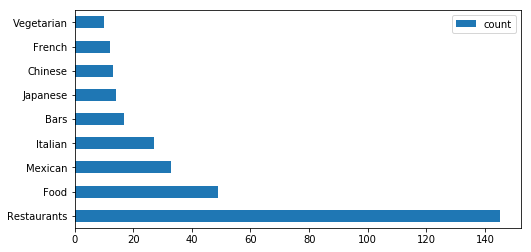

In [24]:
dict[dict['count'] >= 10].sort_values(by='count', ascending=False).plot.barh(figsize=(8,4))

## Most Common Cities of Yelp Food Place

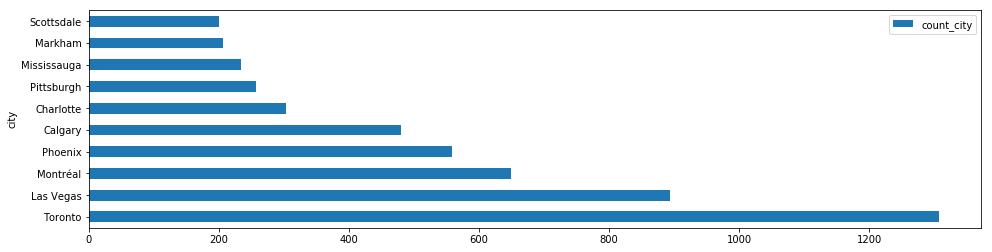

In [25]:
# for index, row in fbiz[['name', 'categories', 'latitude', 'longitude']].iterrows():
#     folium.Marker([row['latitude'], row['longitude']], icon=folium.Icon(color='red')).add_to(m)
    
fbiz['count_city'] = fbiz.groupby('city')['city'].transform('count')
fbiz[['city','count_city']].drop_duplicates('city').sort_values(by='count_city', ascending=False).head(10).plot.barh(x='city', figsize=(16,4))

## Get Lat/Long from city input

[i] City Name? Toronto

In [26]:
m = folium.Map(
    zoom_start=12,
    control_scale=True,
    prefer_canvas=True,
    tiles='OpenStreetMap',
    location=[43.6532, -79.3832]
)
url = ('https://s3-media2.fl.yelpcdn.com/assets/srv0/styleguide/96b838280c20/assets/img/brand_guidelines/dont_rearrange.png')
FloatImage(url, bottom=2, left=77).add_to(m)
m.add_child(MeasureControl())

fbiz['latitude'] = fbiz['latitude'].astype(float)
fbiz['longitude'] = fbiz['longitude'].astype(float)

fbiz['stars'] = fbiz['stars'].astype(float)
fbiz.head()
heat_data = [[[row['latitude'],row['longitude']] for index, row in fbiz[fbiz['stars'] == i].iterrows()] for i in np.linspace(0,5,11)]
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(m)

## Heatmap by Stars of Food Place

In [27]:
import cairocffi

m

## Wrangling Check-in Dataset

In [28]:
fcheck = checkin.join(fbiz[['business_id', 'is_open']].set_index('business_id'), on='business_id', how='inner')

dates = []
business_ids = []
is_opens = []
for index, row in fcheck.iterrows():
    is_open = row.is_open
    business_id = row.business_id
    for d in row.date.split(','):
        business_ids.append(business_id)
        dates.append(d)
        is_opens.append(is_open)
fchecks = pd.DataFrame({
    "business_id": business_ids,
    "date": dates,
    "is_open": is_opens
})

In [29]:
y_pattern = "201+[0-9]{1}"

In [30]:
year = []
for index, row in fchecks.iterrows():
#     year.append(row['date'])
    r = re.search(y_pattern, row['date'])
    year.append(r.group())

In [31]:
fchecks['year'] = year

In [32]:
fchecks['count'] = fchecks.groupby(['business_id', 'year']).cumcount() +1

In [33]:
fc_count = fchecks.sort_values(by='count', ascending=False).drop_duplicates(subset=['business_id', 'year'], keep='first')

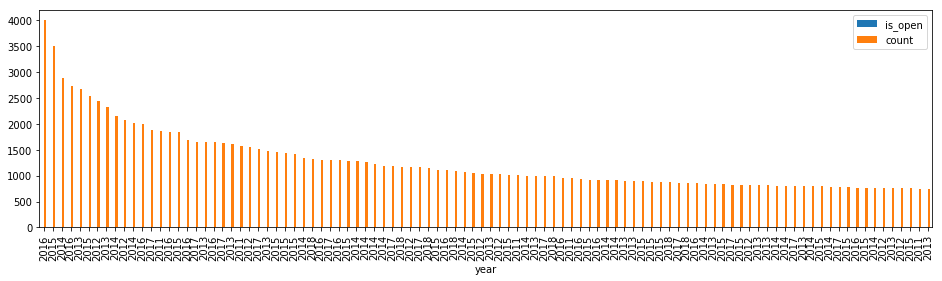

In [34]:
fc_count.sort_values(by='count', ascending=False).head(100).plot.bar(x='year', figsize=(16,4))

## Histogram of Check-in Frequency

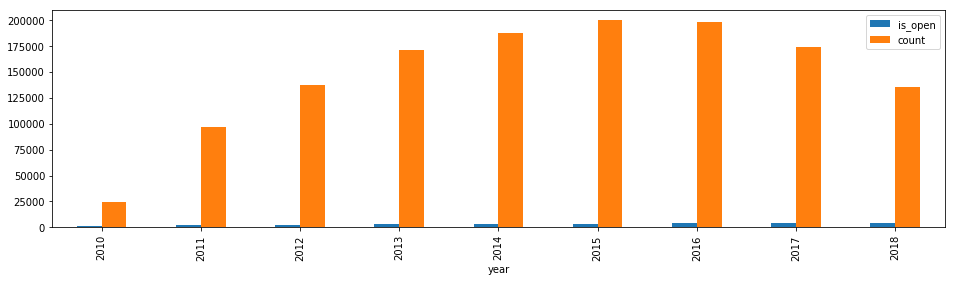

In [35]:
fc_count.groupby('year').sum().plot.bar(figsize=(16,4))

In [36]:
fcb = pd.merge(fc_count, fbiz[['business_id', 'name', 'categories', 'latitude', 'longitude', 'review_count', 'stars']], on='business_id')

In [37]:
m = folium.Map(
    zoom_start=12,
    control_scale=True,
    prefer_canvas=True,
    tiles='OpenStreetMap',
    location=[43.6532, -79.3832]
)
url = ('https://s3-media2.fl.yelpcdn.com/assets/srv0/styleguide/96b838280c20/assets/img/brand_guidelines/dont_rearrange.png')
FloatImage(url, bottom=2, left=77).add_to(m)
m.add_child(MeasureControl())

fcb['latitude'] = fcb['latitude'].astype(float)
fcb['longitude'] = fcb['longitude'].astype(float)

fcb['year'] = fcb['year'].astype(float)
heat_data = [[[row['latitude'],row['longitude']] for index, row in fcb[fcb['year'] == i].iterrows()] for i in np.linspace(2011,2018,8)]
hm = plugins.HeatMapWithTime(heat_data, auto_play=True, max_opacity=0.8)
hm.add_to(m)

## Heatmap by Years of Food Place

## Joining Checkin and Business Dataset

In [38]:
fcbiz = pd.DataFrame(fbiz.categories.str.split(',').tolist(), index=fbiz.business_id).stack()

In [39]:
fcb = pd.merge(fc_count, fbiz[['business_id', 'name', 'categories', 'latitude', 'longitude', 'review_count', 'stars']], on='business_id')

In [40]:
fcbiz = pd.DataFrame(fcbiz).reset_index()

In [41]:
fcbiz = pd.merge(fcbiz, fbiz[['business_id', 'name', 'latitude', 'longitude', 'review_count', 'stars']], on='business_id')
fcbiz.head()

,business_id,level_1,0,name,latitude,longitude,review_count,stars
0,fweCYi8FmbJXHCqLnwuk8w,0,Italian,Marco's Pizza,41.708520,-81.359556,16,4.0
1,fweCYi8FmbJXHCqLnwuk8w,1,Restaurants,Marco's Pizza,41.708520,-81.359556,16,4.0
2,fweCYi8FmbJXHCqLnwuk8w,2,Pizza,Marco's Pizza,41.708520,-81.359556,16,4.0
3,fweCYi8FmbJXHCqLnwuk8w,3,Chicken Wings,Marco's Pizza,41.708520,-81.359556,16,4.0
4,tstimHoMcYbkSC4eBA1wEg,0,Mexican,Maria's Mexican Restaurant & Bakery,36.195615,-115.040529,184,4.5


In [42]:
indices = []
for i, category in enumerate(business.categories):
    if category is None:
        continue
    if any(elem in category.split(',') for elem in authentic):
        indices.append(i)

In [43]:
top_categories = fcbiz.groupby(0).count().sort_values(by='business_id', ascending=False).head(20).reset_index()[0]

In [44]:
common_biz = fcbiz[fcbiz[0].isin(top_categories)]
top_categories = common_biz.groupby(0).count().sort_values(by='business_id', ascending=False).reset_index()[0][0:20]

In [45]:
category_dict = {x: i for i, x in enumerate(top_categories)}
common_biz['category'] = common_biz[0].replace(category_dict)

C:\Users\Glen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [46]:
pd.DataFrame(top_categories).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Restaurants,Mexican,Chinese,Italian,Food,Japanese,Pizza,Indian,Vietnamese,Sushi Bars,Fast Food,Nightlife,Bars,Asian Fusion,Greek,French,Korean,Seafood,Sandwiches,Mediterranean


In [47]:
m = folium.Map(
    zoom_start=12,
    control_scale=True,
    prefer_canvas=True,
    tiles='OpenStreetMap',
    location=[43.6532, -79.3832]
)
url = ('https://s3-media2.fl.yelpcdn.com/assets/srv0/styleguide/96b838280c20/assets/img/brand_guidelines/dont_rearrange.png')
FloatImage(url, bottom=2, left=77).add_to(m)
m.add_child(MeasureControl())

common_biz['latitude'] = common_biz['latitude'].astype(float)
common_biz['longitude'] = common_biz['longitude'].astype(float)

common_biz['category'] = common_biz['category'].astype(float)
heat_data = [[[row['latitude'],row['longitude']] for index, row in common_biz[common_biz['category'] == i].iterrows()] for i in np.linspace(0,19,20)]
hm = plugins.HeatMapWithTime(heat_data, auto_play=True, max_opacity=0.8)
hm.add_to(m)


C:\Users\Glen\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Glen\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\Glen\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

## Heatmap of Most Common Food Category

In [48]:
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 100px;'>
     
<div class='legend-title'>Food Category</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:orange;opacity:1;'></span>0	Restaurants</li>
    <li><span style='background:orange;opacity:0.95;'></span>1	Mexican</li>
    <li><span style='background:orange;opacity:0.9;'></span>2	Chinese</li>
    <li><span style='background:orange;opacity:0.85;'></span>3	Italian</li>
    <li><span style='background:orange;opacity:0.8;'></span>4	Food</li>
    <li><span style='background:orange;opacity:0.75;'></span>5	Japanese</li>
    <li><span style='background:orange;opacity:0.7;'></span>6	Pizza</li>
    <li><span style='background:orange;opacity:0.65;'></span>7	Indian</li>
    <li><span style='background:orange;opacity:0.6;'></span>8	Vietnamese</li>
    <li><span style='background:orange;opacity:0.55;'></span>9	Sushi Bars</li>
    <li><span style='background:orange;opacity:0.5;'></span>10	Fast Food</li>
    <li><span style='background:orange;opacity:0.45;'></span>11	Nightlife</li>
    <li><span style='background:orange;opacity:0.4;'></span>12	Bars</li>
    <li><span style='background:orange;opacity:0.35;'></span>13	Asian Fusion</li>
    <li><span style='background:orange;opacity:0.3;'></span>14	Greek</li>
    <li><span style='background:orange;opacity:0.25;'></span>15	French</li>
    <li><span style='background:orange;opacity:0.2;'></span>16	Korean</li>
    <li><span style='background:orange;opacity:0.15;'></span>17	Seafood</li>
    <li><span style='background:orange;opacity:0.1;'></span>18	Sandwiches</li>
    <li><span style='background:orange;opacity:0.05;'></span>19	Mediterranean</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

m.get_root().add_child(macro)

In [49]:
tips.head()

,business_id,compliment_count,date,text,user_id
0,VaKXUpmWTTWDKbpJ3aQdMw,0,2014-03-27 03:51:24,"Great for watching games, ufc, and whatever el...",UPw5DWs_b-e2JRBS-t37Ag
1,OPiPeoJiv92rENwbq76orA,0,2013-05-25 06:00:56,Happy Hour 2-4 daily with 1/2 price drinks and...,Ocha4kZBHb4JK0lOWvE0sg
2,5KheTjYPu1HcQzQFtm4_vw,0,2011-12-26 01:46:17,Good chips and salsa. Loud at times. Good serv...,jRyO2V1pA4CdVVqCIOPc1Q
3,TkoyGi8J7YFjA6SbaRzrxg,0,2014-03-23 21:32:49,The setting and decoration here is amazing. Co...,FuTJWFYm4UKqewaosss1KA
4,AkL6Ous6A1atZejfZXn1Bg,0,2012-10-06 00:19:27,Molly is definately taking a picture with Sant...,LUlKtaM3nXd-E4N4uOk_fQ


In [50]:
ftips = tips.join(fbiz[['business_id', 'categories', 'city']].set_index('business_id'), on='business_id', how='inner')

In [51]:
ftips.tail()

,business_id,compliment_count,date,text,user_id,categories,city
1217891,-1u4Q4U6OZ-CvqoxUh7gKg,0,2018-09-03 22:14:27,"Authentic Spanish food, great Sangria and tapas!",0XFztFPJpCFxyMvfvLuQwQ,"Spanish, Tapas Bars, Tapas/Small Plates, Resta...",Calgary
1218956,M5rnBQaFtjYTn3T9NIZwcA,0,2015-08-26 23:12:39,"Food was good, price was good and fast service",U1GTUg6YgYIb-UBNCvwqIA,"Chinese, Restaurants",Mc Donald
1221580,J2yHV9KNwBHD7bnGMANCpw,0,2016-08-23 00:38:58,Our family went here and really enjoyed our me...,C52j3UfKcQ2ncjuf950a4w,"Mexican, Restaurants",Phoenix
1221897,N3ZbTZfWC_oyIUxuX9KJYA,0,2018-06-09 15:48:32,Food was good but their sushi needs work... sh...,x1N0ytaGRjNqd1woPSk4zA,"Japanese, Fast Food, Restaurants, Chinese",East Cleveland
1222524,P2l7s26bzzN_QgkWSVg3sw,0,2010-05-09 20:40:10,...then to the art fest!,TO4FGXDJmIDk-sFFntff8A,"Mexican, Restaurants",Henderson


In [52]:
top = ftips.groupby('business_id')['text'] \
        .count() \
        .sort_values(ascending=False)
top.head(10)

business_id
yfxDa8RFOvJPQh0rNtakHA    1117
RwMLuOkImBIqqYj4SSKSPg     748
JDZ6_yycNQFTpUZzLIKHUg     610
rcaPajgKOJC2vo_l3xa42A     568
j5nPiTwWEFr-VsePew7Sjg     546
DzKl51tivGJMLiNsQqf38w     486
frCxZS7lPhEnQRJ3UY6m7A     395
n_K2xa_nqzUqaUJa0S_5tQ     394
q-zZgXKAQFLEgMp9ZNllgQ     363
wpnLPAnkMEb1NpC3xiD_qg     333
Name: text, dtype: int64

In [53]:
from nltk.tokenize import TweetTokenizer
T = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

In [54]:
ftips['tokens'] = ftips['text'].apply(T.tokenize)

In [55]:
subset = ftips['city'] == 'Toronto'
freq = pd.DataFrame({'all':Counter(concat(ftips['tokens'])),
                     'city':Counter(concat(ftips[subset]['tokens']))})

In [56]:
freq['pmi'] = np.log2( ( freq['city'] * np.sum(freq['all']) ) /
                       ( freq['all'] * np.sum(freq['city']) ) )

In [57]:
freq[freq['city']>100].sort_values('pmi', ascending=False).head(20)

,all,city,pmi
toronto,189,135.0,3.034272
cash,870,239.0,1.655695
ramen,596,153.0,1.557919
patio,540,105.0,1.157129
noodles,774,124.0,0.877706
10,1001,159.0,0.865356
small,1134,173.0,0.807123
only,2388,359.0,0.785952
you're,781,112.0,0.717875
dishes,840,118.0,0.688097


In [2]:
with open('review.json', encoding='utf8') as f:
    data = [json.loads(row) for row in f]

reviews = pd.DataFrame(data)
reviews.shape

(6685900, 9)

In [ ]:
reviews.head()

In [3]:
top = reviews.groupby('user_id')['review_id'] \
        .count() \
        .sort_values(ascending=False)
top.head(10)

user_id
CxDOIDnH8gp9KXzpBHJYXw    4129
bLbSNkLggFnqwNNzzq-Ijw    2354
PKEzKWv_FktMm2mGPjwd0Q    1822
ELcQDlf69kb-ihJfxZyL0A    1764
DK57YibC5ShBmqQl97CKog    1727
U4INQZOPSUaj8hMjLlZ3KA    1559
QJI9OSEn6ujRCtrX06vs1w    1496
d_TBs6J3twMy9GChqUEXkg    1360
hWDybu_KvYLSdEFzGrniTw    1355
cMEtAiW60I5wE_vLfTxoJQ    1255
Name: review_id, dtype: int64

In [4]:
top.plot()

% of comments from users who only reviewed once. (In Reddit-Politics, it was 41.5%)

In [6]:
pd.DataFrame(top).head()

,review_id
user_id,
CxDOIDnH8gp9KXzpBHJYXw,4129
bLbSNkLggFnqwNNzzq-Ijw,2354
PKEzKWv_FktMm2mGPjwd0Q,1822
ELcQDlf69kb-ihJfxZyL0A,1764
DK57YibC5ShBmqQl97CKog,1727


In [7]:
sum(pd.DataFrame(top).review_id==1) / sum(pd.DataFrame(top).review_id) * 100

12.840201020057135

% of comments from top 50 reviewers (In Reddit-Politics, 11.2%)

In [8]:
top = pd.DataFrame(top)
one = pd.DataFrame(top[top['review_id']==1])

In [9]:
sum(top.review_id.head(50)) / sum(top.review_id) * 100

0.8445085927100316

In [10]:
sum(top.review_id.head(50)) / len(top) * 100

3.448884577842552

In [11]:
sum(top.review_id >=100)/len(top)*100

0.28042840615757497

In [12]:
len(top.review_id)*sum(top.review_id >=100)/len(top)*100

459100.0

In [13]:
len(top[0:459100])/len(top)

0.28042840615757497

In [14]:
sum(top.review_id)

6685900

In [15]:
topreview = reviews[reviews.user_id.isin(top.index[0:100])]

In [16]:
r100 = pd.DataFrame(top[top['review_id']>=100])

In [17]:
onereview = reviews[reviews.user_id.isin(one.index)]

In [18]:
review100 = reviews[reviews.user_id.isin(r100.index)]

### Distribution of Star-ratings by 100 most frequently reviewed users

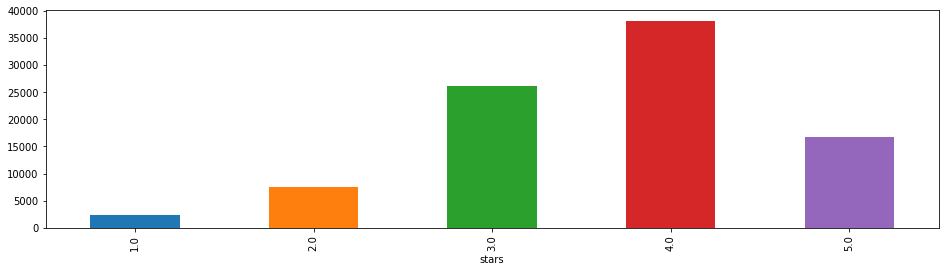

In [19]:
topreview.groupby('stars').size().plot.bar(figsize=(16,4))

### Distribution of Star-ratings by users who reviewed more then 100 times

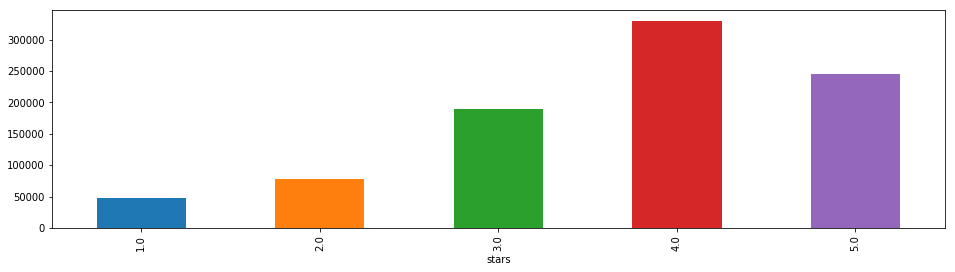

In [20]:
review100.groupby('stars').size().plot.bar(figsize=(16,4))

### Distribution of Star-Ratings by users who reviewed once

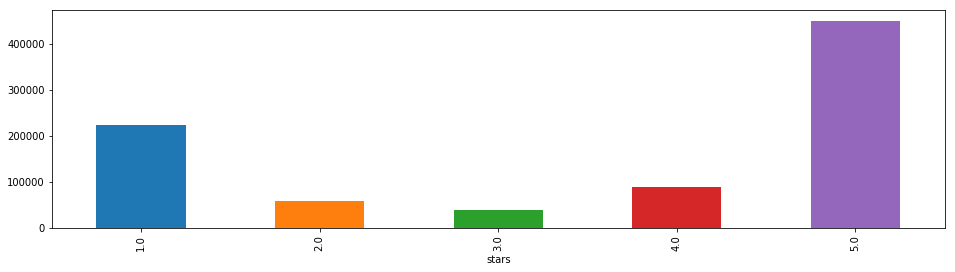

In [21]:
onereview.groupby('stars').size().plot.bar(figsize=(16,4))

In [36]:
fbiz.columns = ['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'postal_code',
       'review_count', 'stars_business', 'state']

In [37]:
fbiz_cn = fbiz[fbiz['categories'].str.contains('Chinese')]
fbiz_cn.shape

(1774, 14)

In [38]:
fbiz_jp = fbiz[fbiz['categories'].str.contains('Japanese')]
fbiz_jp.shape

(957, 14)

In [39]:
fbiz_in = fbiz[fbiz['categories'].str.contains('Indian')]
fbiz_in.shape

(656, 14)

In [40]:
fbiz_vn = fbiz[fbiz['categories'].str.contains('Vietnamese')]
fbiz_vn.shape

(541, 14)

In [41]:
fbiz_ss = fbiz[fbiz['categories'].str.contains('Sushi Bars')]
fbiz_ss.shape

(464, 14)

In [42]:
fbiz_af = fbiz[fbiz['categories'].str.contains('Asian Fusion')]
fbiz_af.shape

(372, 14)

In [43]:
fbiz_kr = fbiz[fbiz['categories'].str.contains('Korean')]
fbiz_kr.shape

(361, 14)

## Save review+business DataFrame into csv by each Category

In [44]:
freview_cn = reviews.join(fbiz_cn[['business_id', 'categories', 'stars_business']].set_index('business_id'), on='business_id', how='inner')

In [45]:
freview_cn.to_csv('freview_cn.csv', index=True)

In [46]:
freview_jp = reviews.join(fbiz_jp[['business_id', 'categories', 'stars_business']].set_index('business_id'), on='business_id', how='inner')
freview_jp.to_csv('freview_jp.csv', index=True)

In [47]:
freview_in = reviews.join(fbiz_in[['business_id', 'categories', 'stars_business']].set_index('business_id'), on='business_id', how='inner')
freview_in.to_csv('freview_in.csv', index=True)

In [48]:
freview_vn = reviews.join(fbiz_vn[['business_id', 'categories', 'stars_business']].set_index('business_id'), on='business_id', how='inner')
freview_vn.to_csv('freview_vn.csv', index=True)

In [49]:
freview_ss = reviews.join(fbiz_ss[['business_id', 'categories', 'stars_business']].set_index('business_id'), on='business_id', how='inner')
freview_ss.to_csv('freview_ss.csv', index=True)

In [50]:
freview_af = reviews.join(fbiz_af[['business_id', 'categories', 'stars_business']].set_index('business_id'), on='business_id', how='inner')
freview_af.to_csv('freview_af.csv', index=True)

In [51]:
freview_kr = reviews.join(fbiz_kr[['business_id', 'categories', 'stars_business']].set_index('business_id'), on='business_id', how='inner')
freview_kr.to_csv('freview_kr.csv', index=True)

## Load one of the category data (Korean)

In [2]:
freview_kr = pd.read_csv("freview_kr.csv")

In [3]:
from adjustText import adjust_text
from scipy.cluster import hierarchy
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import *
from sklearn.preprocessing import *
from sklearn.cluster import *
from sklearn.decomposition import *
from sklearn.manifold import *
from sklearn.neighbors import *
nlp = spacy.load('en')
def tokenize(text):
    return [tok.lower_ for tok in nlp.tokenizer(text)]

In [4]:
freview_kr['tokens'] = freview_kr['text'].apply(tokenize)

In [5]:
V = CountVectorizer(analyzer=identity, min_df=50, max_df=0.50)
D = V.fit_transform(freview_kr.groupby('text')['tokens'].apply(concat))
D.shape

(33643, 3252)

In [209]:
type(D)

scipy.sparse.csr.csr_matrix

In [6]:
import pickle
from cytoolz import identity, take
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus

C:\Users\Glen\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [145]:
corpus = Sparse2Corpus(D, documents_columns=False)

In [139]:
print(corpus)

In [8]:
vocab = corpora.dictionary.Dictionary()
vocab.token2id = dict((w,i) for (i,w) in enumerate(V.get_feature_names()))
vocab.id2token = dict(enumerate(V.get_feature_names()))

In [146]:
type(corpus)

gensim.matutils.Sparse2Corpus

## Topic Model

In [23]:
import logging
>>> logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [92]:
vocab.id2token

{0: '\r\n',
 1: '\r\n\r\n',
 2: '\r\n\r\n\r\n',
 3: '\r\n\r\n ',
 4: '\r\n ',
 5: '\r\n \r\n',
 6: ' ',
 7: ' \r\n',
 8: ' \r\n\r\n',
 9: '  ',
 10: '  \r\n\r\n',
 11: '   ',
 12: '!',
 13: '"',
 14: '#',
 15: '$',
 16: '%',
 17: '&',
 18: "'",
 19: "'d",
 20: "'ll",
 21: "'m",
 22: "'re",
 23: "'s",
 24: "'ve",
 25: '(',
 26: ')',
 27: '*',
 28: '+',
 29: '-',
 30: '--',
 31: '..',
 32: '...',
 33: '....',
 34: '.....',
 35: '......',
 36: '/',
 37: '0',
 38: '1',
 39: '1.5',
 40: '1/2',
 41: '10',
 42: '10.99',
 43: '10/10',
 44: '100',
 45: '11',
 46: '12',
 47: '12.99',
 48: '13',
 49: '13.99',
 50: '14',
 51: '15',
 52: '16',
 53: '16.99',
 54: '17',
 55: '18',
 56: '19.99',
 57: '1st',
 58: '2',
 59: '2.5',
 60: '2/5',
 61: '20',
 62: '21',
 63: '22',
 64: '23',
 65: '24',
 66: '24/7',
 67: '24hrs',
 68: '25',
 69: '27',
 70: '28',
 71: '2nd',
 72: '3',
 73: '3.5',
 74: '3.5/5',
 75: '3/5',
 76: '30',
 77: '35',
 78: '3rd',
 79: '4',
 80: '4.5',
 81: '4/5',
 82: '40',
 83: '45',


In [89]:
import gensim
lsi = gensim.models.lsimodel.LsiModel(corpus, id2word=vocab.id2token, num_topics=20)

2019-05-15 15:25:28,404 : INFO : using serial LSI version on this node
2019-05-15 15:25:28,407 : INFO : updating model with new documents
2019-05-15 15:25:28,879 : INFO : preparing a new chunk of documents
2019-05-15 15:25:29,465 : INFO : using 100 extra samples and 2 power iterations
2019-05-15 15:25:29,468 : INFO : 1st phase: constructing (3252, 120) action matrix
2019-05-15 15:25:29,786 : INFO : orthonormalizing (3252, 120) action matrix
2019-05-15 15:25:30,833 : INFO : 2nd phase: running dense svd on (120, 20000) matrix
2019-05-15 15:25:31,597 : INFO : computing the final decomposition
2019-05-15 15:25:31,600 : INFO : keeping 20 factors (discarding 29.689% of energy spectrum)
2019-05-15 15:25:31,609 : INFO : processed documents up to #20000
2019-05-15 15:25:31,614 : INFO : topic #0(991.996): 0.263*" " + 0.258*"

" + 0.223*"that" + 0.213*"we" + 0.209*"!" + 0.198*"with" + 0.194*"you" + 0.173*"they" + 0.169*"my" + 0.164*"n't"
2019-05-15 15:25:31,618 : INFO : topic #1(414.401): 0.953*"

In [90]:
lsi.print_topics(20)

2019-05-15 15:25:45,958 : INFO : topic #0(1259.401): 0.268*" " + 0.253*"

" + 0.229*"we" + 0.219*"that" + 0.213*"!" + 0.198*"you" + 0.196*"with" + 0.174*"they" + 0.163*"n't" + 0.161*"my"
2019-05-15 15:25:45,962 : INFO : topic #1(533.199): -0.951*" " + 0.141*"

" + 0.141*"!" + 0.085*"we" + 0.065*"
" + 0.050*"they" + 0.050*"you" + 0.048*"n't" + 0.045*"so" + -0.045*" 

"
2019-05-15 15:25:45,966 : INFO : topic #2(441.378): 0.936*"!" + -0.143*"we" + -0.111*"that" + -0.086*"were" + 0.077*" " + -0.073*"n't" + -0.070*"

" + -0.068*"not" + -0.054*"as" + -0.052*"-"
2019-05-15 15:25:45,971 : INFO : topic #3(396.181): -0.688*"we" + 0.328*"you" + -0.221*"were" + -0.205*"our" + 0.196*"-" + 0.189*"

" + -0.155*"us" + 0.134*"'s" + -0.133*"!" + 0.120*"are"
2019-05-15 15:25:45,974 : INFO : topic #4(330.261): -0.417*"you" + 0.411*"-" + 0.308*"

" + 0.253*")" + 0.247*"
" + 0.239*"(" + -0.190*"they" + 0.179*"with" + -0.158*"that" + -0.138*"n't"
2019-05-15 15:25:45,978 : INFO : topic #5(277.689): 0.516*"you

[(0,
  '0.268*" " + 0.253*"\r\n\r\n" + 0.229*"we" + 0.219*"that" + 0.213*"!" + 0.198*"you" + 0.196*"with" + 0.174*"they" + 0.163*"n\'t" + 0.161*"my"'),
 (1,
  '-0.951*" " + 0.141*"\r\n\r\n" + 0.141*"!" + 0.085*"we" + 0.065*"\r\n" + 0.050*"they" + 0.050*"you" + 0.048*"n\'t" + 0.045*"so" + -0.045*" \r\n\r\n"'),
 (2,
  '0.936*"!" + -0.143*"we" + -0.111*"that" + -0.086*"were" + 0.077*" " + -0.073*"n\'t" + -0.070*"\r\n\r\n" + -0.068*"not" + -0.054*"as" + -0.052*"-"'),
 (3,
  '-0.688*"we" + 0.328*"you" + -0.221*"were" + -0.205*"our" + 0.196*"-" + 0.189*"\r\n\r\n" + -0.155*"us" + 0.134*"\'s" + -0.133*"!" + 0.120*"are"'),
 (4,
  '-0.417*"you" + 0.411*"-" + 0.308*"\r\n\r\n" + 0.253*")" + 0.247*"\r\n" + 0.239*"(" + -0.190*"they" + 0.179*"with" + -0.158*"that" + -0.138*"n\'t"'),
 (5,
  '0.516*"you" + 0.391*"we" + -0.358*"my" + 0.282*"\r\n" + 0.245*"-" + -0.180*"with" + -0.153*"that" + -0.152*"had" + -0.106*"good" + -0.106*"me"'),
 (6,
  '0.705*"\r\n" + -0.527*"\r\n\r\n" + 0.180*"they" + -0.150*"y

In [29]:
from gensim import models
tfidf = models.TfidfModel(corpus)

2019-05-15 10:23:53,183 : INFO : collecting document frequencies
2019-05-15 10:23:53,187 : INFO : PROGRESS: processing document #0
2019-05-15 10:23:53,681 : INFO : PROGRESS: processing document #10000
2019-05-15 10:23:54,225 : INFO : PROGRESS: processing document #20000
2019-05-15 10:23:54,680 : INFO : PROGRESS: processing document #30000
2019-05-15 10:23:54,869 : INFO : calculating IDF weights for 33643 documents and 3251 features (2137430 matrix non-zeros)


In [120]:
with  open('fbiz_kr.dat', 'wb') as f:
    pickle.dump((vocab, corpus), f, -1)

In [42]:
tfidf = models.TfidfModel(corpus)

2019-05-15 14:29:16,450 : INFO : collecting document frequencies
2019-05-15 14:29:16,454 : INFO : PROGRESS: processing document #0
2019-05-15 14:29:16,932 : INFO : PROGRESS: processing document #10000
2019-05-15 14:29:17,444 : INFO : PROGRESS: processing document #20000
2019-05-15 14:29:17,876 : INFO : PROGRESS: processing document #30000
2019-05-15 14:29:18,068 : INFO : calculating IDF weights for 33643 documents and 3251 features (2137430 matrix non-zeros)


In [64]:
corpus_tfidf = tfidf[corpus]
model = models.LdaModel(corpus, id2word=vocab.id2token, num_topics=20)

2019-05-15 14:42:28,042 : INFO : using symmetric alpha at 0.05
2019-05-15 14:42:28,045 : INFO : using symmetric eta at 0.05
2019-05-15 14:42:28,049 : INFO : using serial LDA version on this node
2019-05-15 14:42:28,067 : INFO : running online (single-pass) LDA training, 20 topics, 1 passes over the supplied corpus of 33643 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2019-05-15 14:42:28,121 : INFO : PROGRESS: pass 0, at document #2000/33643
2019-05-15 14:42:32,374 : INFO : merging changes from 2000 documents into a model of 33643 documents
2019-05-15 14:42:32,388 : INFO : topic #9 (0.050): 0.015*"n't" + 0.014*"we" + 0.014*"

" + 0.012*" " + 0.010*"you" + 0.010*"were" + 0.010*"good" + 0.010*"with" + 0.010*"!" + 0.009*"that"
2019-05-15 14:42:32,392 : INFO : topic #4 (0.050): 0.024*"
" + 0.018*" " + 0.013*"

" + 0.013*"-" + 0.013*"that" + 0.012*")" + 0.011*"(" + 0.010*"with" + 0.010

" + 0.011*"just"
2019-05-15 14:42:53,940 : INFO : topic #13 (0.050): 0.037*"you" + 0.021*"

" + 0.018*"with" + 0.013*"-" + 0.012*"your" + 0.011*"!" + 0.010*"can" + 0.009*"are" + 0.009*")" + 0.008*"pork"
2019-05-15 14:42:53,943 : INFO : topic #9 (0.050): 0.019*"n't" + 0.018*"were" + 0.017*"chicken" + 0.015*"had" + 0.014*"good" + 0.014*"with" + 0.013*"

" + 0.012*"we" + 0.012*"not" + 0.012*"that"
2019-05-15 14:42:53,946 : INFO : topic diff=0.592947, rho=0.377964
2019-05-15 14:42:54,067 : INFO : PROGRESS: pass 0, at document #16000/33643
2019-05-15 14:42:58,050 : INFO : merging changes from 2000 documents into a model of 33643 documents
2019-05-15 14:42:58,066 : INFO : topic #6 (0.050): 0.032*"

" + 0.027*"-" + 0.027*"!" + 0.014*"with" + 0.012*")" + 0.011*"you" + 0.011*"(" + 0.010*"they" + 0.010*":" + 0.010*"bean"
2019-05-15 14:42:58,069 : INFO : topic #7 (0.050): 0.026*")" + 0.025*"(" + 0.025*"-" + 0.015*"they" + 0.015*"

" + 0.011*""" + 0.011*"n't" + 0.011*"that" + 0.011*"'s" + 0.010*"t

" + 0.018*"their" + 0.017*"pork" + 0.017*"bone" + 0.015*"they" + 0.011*"with" + 0.011*"are" + 0.010*"that" + 0.008*"as"
2019-05-15 14:43:22,665 : INFO : topic #2 (0.050): 0.179*"!" + 0.029*"place" + 0.029*"great" + 0.018*"service" + 0.015*"amazing" + 0.015*"korean" + 0.012*"back" + 0.012*"best" + 0.012*"so" + 0.012*"are"
2019-05-15 14:43:22,668 : INFO : topic #16 (0.050): 0.027*"she" + 0.024*""" + 0.022*"that" + 0.022*"my" + 0.021*"..." + 0.018*"?" + 0.016*"me" + 0.015*"n't" + 0.012*"just" + 0.012*"her"
2019-05-15 14:43:22,671 : INFO : topic #17 (0.050): 0.025*"they" + 0.016*"my" + 0.016*"meat" + 0.015*"so" + 0.015*"you" + 0.014*"that" + 0.014*"we" + 0.012*"n't" + 0.012*"place" + 0.012*"were"
2019-05-15 14:43:22,674 : INFO : topic diff=0.362028, rho=0.267261
2019-05-15 14:43:22,771 : INFO : PROGRESS: pass 0, at document #30000/33643
2019-05-15 14:43:25,968 : INFO : merging changes from 2000 documents into a model of 33643 documents
2019-05-15 14:43:25,983 : INFO : topic #1 (0.050): 0.0

In [65]:
model.show_topics()

[(0,
  '0.023*"!" + 0.023*"with" + 0.019*"tofu" + 0.019*"rice" + 0.015*"hot" + 0.015*"korean" + 0.014*"my" + 0.014*"dishes" + 0.014*"kimchi" + 0.012*"spicy"'),
 (13,
  '0.060*"you" + 0.024*"\r\n\r\n" + 0.020*"your" + 0.017*"with" + 0.016*"can" + 0.012*"meat" + 0.011*"-" + 0.011*"pork" + 0.010*"if" + 0.010*"are"'),
 (8,
  '0.024*")" + 0.024*"(" + 0.023*"soup" + 0.019*"with" + 0.016*"\r\n\r\n" + 0.013*"pork" + 0.013*"my" + 0.012*"that" + 0.011*"not" + 0.011*"-"'),
 (1,
  '0.048*"pho" + 0.018*"place" + 0.015*"my" + 0.013*"have" + 0.013*"here" + 0.012*"you" + 0.012*"\'s" + 0.012*"good" + 0.011*"!" + 0.010*"that"'),
 (6,
  '0.033*"\r\n\r\n" + 0.027*"-" + 0.023*"!" + 0.016*"with" + 0.016*")" + 0.016*"bean" + 0.015*"(" + 0.011*"cakes" + 0.010*"red" + 0.010*"ice"'),
 (7,
  '0.053*")" + 0.051*"(" + 0.041*"-" + 0.019*"\r\n\r\n" + 0.015*""" + 0.015*"$" + 0.014*"they" + 0.012*"\'s" + 0.011*"that" + 0.011*"n\'t"'),
 (5,
  '0.046*"sushi" + 0.033*"good" + 0.030*"very" + 0.022*"service" + 0.017*"place

## Topic Matrix

In [98]:
T = lsi.get_topics()
T.shape

(20, 3252)

In [67]:
vocab.token2id['chicken']

607

Topics for which nasa is a frequent word, in ascending order

In [99]:
np.argsort(T[:,607])

array([18, 13, 16,  7, 12, 17,  5,  9,  2, 15,  8,  1,  6,  3, 14, 10,  0,
        4, 11, 19], dtype=int64)

In [100]:
model.print_topic(11), model.print_topic(19)

('0.335*" " + 0.017*" \r\n\r\n" + 0.012*"you" + 0.012*"  " + 0.010*"they" + 0.010*"not" + 0.010*"are" + 0.009*"good" + 0.009*"that" + 0.008*"korean"',
 '0.043*"soup" + 0.032*"\r\n\r\n" + 0.021*"pork" + 0.018*"bone" + 0.017*"their" + 0.014*"they" + 0.012*"with" + 0.010*"are" + 0.009*"that" + 0.009*"other"')

In [69]:
vocab.token2id['banchan']

315

In [101]:
np.argsort(T[:,315])

array([ 8,  7, 15,  6,  2, 19, 11,  5, 10,  1, 18, 13,  3, 17,  9,  0, 12,
        4, 16, 14], dtype=int64)

In [102]:
model.print_topic(16), model.print_topic(14)

('0.027*"she" + 0.024*""" + 0.024*"?" + 0.024*"..." + 0.023*"that" + 0.021*"my" + 0.017*"me" + 0.015*"n\'t" + 0.015*".." + 0.013*"her"',
 '0.104*"we" + 0.040*"were" + 0.029*"our" + 0.017*"\r\n\r\n" + 0.013*"with" + 0.012*"had" + 0.012*"us" + 0.011*"that" + 0.011*"on" + 0.009*"ordered"')

In [103]:
def get_term_topics(term, thresh=0.0001):
    vec = T[:,vocab.token2id[term]]
    for topic in list(np.nonzero(vec > thresh)[0]):
        print(topic, lsi.print_topic(topic))

In [104]:
get_term_topics('chicken')

0 0.268*" " + 0.253*"

" + 0.229*"we" + 0.219*"that" + 0.213*"!" + 0.198*"you" + 0.196*"with" + 0.174*"they" + 0.163*"n't" + 0.161*"my"
1 -0.951*" " + 0.141*"

" + 0.141*"!" + 0.085*"we" + 0.065*"
" + 0.050*"they" + 0.050*"you" + 0.048*"n't" + 0.045*"so" + -0.045*" 

"
3 -0.688*"we" + 0.328*"you" + -0.221*"were" + -0.205*"our" + 0.196*"-" + 0.189*"

" + -0.155*"us" + 0.134*"'s" + -0.133*"!" + 0.120*"are"
4 -0.417*"you" + 0.411*"-" + 0.308*"

" + 0.253*")" + 0.247*"
" + 0.239*"(" + -0.190*"they" + 0.179*"with" + -0.158*"that" + -0.138*"n't"
6 0.705*"
" + -0.527*"

" + 0.180*"they" + -0.150*"you" + 0.136*"good" + -0.118*""" + 0.117*"-" + 0.111*"n't" + -0.102*"we" + 0.098*":"
10 -0.592*"-" + -0.441*"they" + 0.365*"
" + 0.259*"with" + 0.199*"you" + 0.195*"my" + -0.118*"have" + -0.113*"their" + -0.112*"are" + 0.110*":"
11 0.431*"that" + -0.347*"my" + 0.327*"with" + 0.320*"they" + -0.295*"place" + -0.230*"pho" + -0.194*"good" + -0.185*"here" + -0.131*"service" + 0.129*"were"
14 0.551*"korean

In [105]:
get_term_topics('banchan')

0 0.268*" " + 0.253*"

" + 0.229*"we" + 0.219*"that" + 0.213*"!" + 0.198*"you" + 0.196*"with" + 0.174*"they" + 0.163*"n't" + 0.161*"my"
1 -0.951*" " + 0.141*"

" + 0.141*"!" + 0.085*"we" + 0.065*"
" + 0.050*"they" + 0.050*"you" + 0.048*"n't" + 0.045*"so" + -0.045*" 

"
3 -0.688*"we" + 0.328*"you" + -0.221*"were" + -0.205*"our" + 0.196*"-" + 0.189*"

" + -0.155*"us" + 0.134*"'s" + -0.133*"!" + 0.120*"are"
4 -0.417*"you" + 0.411*"-" + 0.308*"

" + 0.253*")" + 0.247*"
" + 0.239*"(" + -0.190*"they" + 0.179*"with" + -0.158*"that" + -0.138*"n't"
9 0.418*"they" + -0.402*"-" + -0.366*"with" + 0.336*")" + 0.318*"(" + 0.247*"

" + 0.244*"n't" + -0.146*"that" + -0.143*"my" + -0.139*"you"
10 -0.592*"-" + -0.441*"they" + 0.365*"
" + 0.259*"with" + 0.199*"you" + 0.195*"my" + -0.118*"have" + -0.113*"their" + -0.112*"are" + 0.110*":"
12 0.507*"that" + -0.314*"my" + -0.310*"they" + 0.278*"korean" + -0.248*"with" + 0.245*"'s" + 0.231*"not" + -0.201*"-" + 0.178*"good" + -0.174*"you"
13 -0.587*"n't" + 0.2

## Document Matrix

Rows in D are documents, columns are topics

In [163]:
corpus.str

AttributeError: 'Sparse2Corpus' object has no attribute 'str'

In [162]:
D = lda._predict(corpus[0][0])

TypeError: 'numpy.int32' object is not iterable

## Latent Semantic Analysis

In [164]:
lsi = make_pipeline(CountVectorizer(analyzer=identity, max_df=0.75, min_df=1), 
                    TfidfTransformer(norm='l2', use_idf=True),
                    TruncatedSVD(50))
lsi.fit(freview_kr['tokens'])

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=<cyfunction identity at 0x00000247E3A089A0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=0.75,
        max_features=None, min_df=1, ngram_range=(1, 1), ...TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0))])

In [165]:
M = lsi.named_steps['truncatedsvd'].components_.T
V = lsi.named_steps['countvectorizer'].get_feature_names()

In [166]:
M[V.index('banchan'),:]

array([ 0.0120354 , -0.00631211, -0.00278289, -0.00311413,  0.02393017,
        0.00036734, -0.00558005, -0.02194749,  0.00929717, -0.02501935,
       -0.01484786, -0.01980819, -0.01393846,  0.006677  , -0.00270218,
       -0.01024955,  0.0080299 ,  0.00955122, -0.00031691, -0.00422641,
       -0.00431191, -0.00324549, -0.00386488, -0.00844794,  0.00148958,
       -0.00620526,  0.00741088,  0.00417693, -0.00964775, -0.00554661,
       -0.00934331,  0.00416851,  0.00201482,  0.00226151,  0.01684651,
        0.00448788,  0.00181173, -0.03315336, -0.00040821,  0.00819022,
       -0.00715513, -0.0119776 , -0.00568866, -0.00156186,  0.00705551,
       -0.00684424, -0.01368491, -0.00330384, -0.0136675 ,  0.00746867])

In [167]:
space = NearestNeighbors().fit(M)

In [168]:
space.kneighbors([M[V.index('banchan'),:]], return_distance=False)

array([[ 5263, 12086, 32060, 15500, 32919]], dtype=int64)

In [170]:
[V[i] for i in space.kneighbors([M[V.index('banchan'),:]], return_distance=False)[0]]

['banchan', 'dolsot', 'soondubu', 'galbi', 'stew']

In [171]:
def sim(word):
    return [V[i] for i in space.kneighbors([M[V.index(word),:]], return_distance=False)[0]]

In [172]:
sim('chicken')

['chicken', 'fried', 'wings', 'half', 'garlic']

In [173]:
sim('price')

['price', 'reasonable', '$', 'special', 'portion']

In [175]:
sim('service')

['service', 'customer', 'fast', 'excellent', 'slow']

In [176]:
sim('location')

['location', 'yonge', 'york', 'locations', 'seems']

In [177]:
sim('fast')

['fast', 'quick', 'busy', 'hours', '24']

In [178]:
sim('kimchi')

['kimchi', 'stew', 'stone', 'bibimbap', 'pot']

In [179]:
def concept(i):
    x = np.zeros(50)
    x[i] = 1
    return [V[i] for i in space.kneighbors([x], return_distance=False)[0]]

In [182]:
for i in range(30):
    print(i, concept(i))

0 ['just', 'or', 'more', 'up', 'on']
1 ['!', 'awesome', 'must', 'yummy', 'super']
2 [' ', ' \r\n\r\n', '  ', ' \r\n', '   ']
3 ['was', 'ordered', 'got', 'us', 'came']
4 [':', 'kimchi', 'sauce', 'spicy', 'tasty']
5 ['atmosphere', 'clean', 'prices', 'tasty', 'nice']
6 ['pho', 'broth', 'bowl', 'vietnamese', 'noodles']
7 ['\r\n', 'pho', 'vietnamese', 'broth', 'spring']
8 ['spring', 'both', 'vietnamese', 'seated', 'egg']
9 ['sushi', 'roll', 'fresh', 'sashimi', 'salmon']
10 ['has', 'me', "'m", 'now', 'roll']
11 ['wings', 'also', 'fried', 'too', 'sauce']
12 ['fries', 'dogs', 'try', 'cheese', 'hot']
13 ['roll', 'places', 'fresh', 'ayce', 'town']
14 ['worth', 'little', 'bit', "'s", 'strip']
15 ['fried', 'chicken', 'wings', 'garlic', 'half']
16 ["'s", 'coming', 'every', 'comes', 'loved']
17 ['dog', 'fries', 'dogs', 'hot', 'angry']
18 ['hot', 'soon', 'clean', 'angry', 'tasty']
19 ['said', 'awesome', 'shit', 'egg', 'what']
20 ['attentive', 'grill', 'helpful', 'meats', 'fresh']
21 ['authentic', 'ar

In [183]:
clusters = AgglomerativeClustering(n_clusters=4).fit_predict(D.toarray())

In [212]:
clusters

array([1, 2, 1, ..., 1, 1, 1], dtype=int64)

In [191]:
Z = hierarchy.linkage(D.toarray(), 'ward')

In [192]:
labels = freview_kr.groupby('stars')['stars'].apply(pd.unique).index

In [197]:
import matplotlib.pyplot as plt
hierarchy.dendrogram(Z, labels=labels, orientation='left')
plt.show()

IndexError: index -28945 is out of bounds for axis 0 with size 5

In [213]:
def print_top_feats(M, k=0):
    V = M.named_steps['countvectorizer'].get_feature_names()
    coef = M.named_steps['logisticregression'].coef_[0]
    order = coef.argsort()
    for w1, w2 in zip(order[-k:][::-1],order[:k]):
        print(f'{V[w1]:20s} {coef[w1]:6.3f} | {V[w2]:20s} {coef[w2]:6.3f}')

In [216]:
from sklearn.feature_extraction.text import *
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.dummy import *

In [226]:
train,test = train_test_split(freview_kr.index,
                             test_size=0.2,
                             stratify=freview_kr['stars_business'],
                             random_state=42)

In [232]:
freview_kr.head()

,Unnamed: 0,business_id,cool,date,funny,review_id,stars,text,useful,user_id,categories,stars_business,tokens
0,185,SAfuIUZMXrOnb3LWyvYjDA,0,2015-10-23 09:26:14,0,Zs8XxGLn1z7R2bae9MBOpA,4.0,"Great environment, I loved their meat jun. Ver...",0,24a7xwHNCR2t0ZDl80-DaA,"Korean, Restaurants",3.5,"[great, environment, ,, i, loved, their, meat,..."
1,2886,SAfuIUZMXrOnb3LWyvYjDA,2,2015-07-03 19:08:02,0,lbYUP6Xl4aBJuCxgWadTJA,3.0,The meat jun is a solid four stars. The thinly...,2,sAOdKC09kMqFfnVCrJRWvQ,"Korean, Restaurants",3.5,"[the, meat, jun, is, a, solid, four, stars, .,..."
2,3218,SAfuIUZMXrOnb3LWyvYjDA,0,2012-02-01 06:37:45,1,zn2V4BJhU0HnreFQdaG_TQ,4.0,Sooooo yummmmy! Closest to yummys in Hawaii a...,2,zzPvEodjvLPe-5NvV0U_cg,"Korean, Restaurants",3.5,"[sooooo, yummmmy, !, , closest, to, yummys, i..."
3,7778,SAfuIUZMXrOnb3LWyvYjDA,0,2015-08-06 22:18:12,0,ox3p_Z8_fYI8xMkINKsApg,2.0,Jun's Special - all of the meat was really tas...,1,1HeGzuKCjUirsjN1O-O4tw,"Korean, Restaurants",3.5,"[jun, 's, special, -, all, of, the, meat, was,..."
4,7780,SAfuIUZMXrOnb3LWyvYjDA,0,2011-04-22 03:48:23,0,PRsI9NG-ZBvOf9mt8KwIyg,4.0,My first time here...service is awesome. Order...,0,e7uW3Knz3ZAi2s-8mhhltA,"Korean, Restaurants",3.5,"[my, first, time, here, ..., service, is, awes..."


In [233]:
V = make_pipeline(CountVectorizer(analyzer=identity),
                     LogisticRegression(solver='liblinear'))
V.fit(freview_kr.loc[:]['tokens'], freview_kr.loc[:]['stars'])

C:\Users\Glen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=<cyfunction identity at 0x00000247E3A089A0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), p...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [255]:
print_top_feats(V,50)

worst                 1.939 | amazing              -1.615
horrible              1.601 | delicious            -1.604
awful                 1.568 | excellent            -1.531
disgusting            1.502 | great                -1.310
terrible              1.316 | awesome              -1.261
zero                  1.111 | best                 -1.056
coming_never          1.061 | stars                -1.040
never                 1.061 | love                 -0.998
dirty                 0.980 | nice                 -0.951
poisoning             0.965 | fast                 -0.950
poisoning_food        0.961 | favorite             -0.921
recommend_not         0.937 | friendly             -0.912
gross                 0.898 | stars_2              -0.856
bad_very              0.897 | always               -0.808
waste                 0.890 | love_.               -0.805
star_1                0.889 | quick                -0.788
service_horrible      0.871 | happy                -0.787
disappointed_v

In [239]:
freview_kr.loc[14]['stars'], V.predict([freview_kr.loc[141]['tokens']])[0]

(3.0, 4.0)

In [240]:
freview_kr.loc[14]['text']

"Went today for the first time and it's not bad! There are better Korean restaurants out there in my opinion, but that doesn't mean I wouldn't come back here! \r\n\r\nI ordered the Jun Special Combo because I wanted to be able to try a little bit of everything and it was quite good. My uncle got the bimbimbap and that was delicious! My cousin got the meat jun.  All the food was good, not spectacular, but good :) \r\n\r\nThe service was kinda ehhh haha She got us our drinks and took our orders, but she rarely checked on us and even though the restaurant is small it was kinda hard to flag her down to get our check. The water tasted kinda funny too in my opinion. I think my favorite thing is that you can order the side dishes in cartons to go! I will definitely be going back to get a small container of bean sprouts, my fav! \r\n\r\nAll in all, worth a try and the prices aren't bad!"

In [242]:
from spacy.tokens import Token
Token.set_extension('neg', default=False, force=True)

In [249]:
freview_kr['doc'] = list(nlp.pipe(freview_kr['text']))

In [251]:
def negify(tok):
    return 'NOT:' + tok.lower_ if tok._.neg else tok.lower_

def mods(doc):
    return [ negify(w.head) + '_' + negify(w) for w in doc 
            if w.dep_ in ['amod', 'advmod'] ] + \
            [ negify(w) for w in doc]

freview_kr['mods'] = freview_kr['doc'].apply(mods)

In [252]:
def everything(doc):
    return [ negify(w.head) + '_' + negify(w) for w in doc  
            if w.head != w ] + \
            [ negify(w) for w in doc]

freview_kr['mods'] = freview_kr['doc'].apply(everything)

In [254]:
V.fit(freview_kr.loc[:]['mods'], freview_kr.loc[:]['stars'])

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=<cyfunction identity at 0x00000247E3A089A0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), p...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [256]:
subset = freview_kr['business_id'] == 'SAfuIUZMXrOnb3LWyvYjDA'
freq = pd.DataFrame({'all':Counter(concat(freview_kr['tokens'])),
                     'business':Counter(concat(freview_kr[subset]['tokens']))})

In [258]:
freq['pmi'] = np.log2( ( freq['business'] * np.sum(freq['all']) ) /
                       ( freq['all'] * np.sum(freq['business']) ) )

In [259]:
freq[freq['business']>100].sort_values('pmi', ascending=False).head(20)

,all,business,pmi
jun,391,243.0,6.202920
meat,7237,213.0,1.802665
korean,17044,338.0,1.233035
's,21081,314.0,0.820097
,39179,550.0,0.734627
spicy,7555,102.0,0.678341
food,29702,363.0,0.534685
my,28199,319.0,0.423188
go,9453,106.0,0.410496
get,10365,114.0,0.382589


# Technical Diffciculties
#### - Wrangling .json data
#### - Filtering food categories
#### - Short of local data
<p>

# Future Recommendations
#### - Correlation between variables (time, checkin, stars, food categories)
#### - Visualizing clusters by food category
#### - Research on why people are more strict on Food Places